In [1]:
#drive.mount("/content/drive", force_remount=True)

NameError: ignored

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import multiprocessing
import numpy as np
import cv2
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

In [4]:
!nvidia-smi

Tue May  4 11:58:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
root_dir = '/content/drive/MyDrive/Models_exp3.1'

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device = torch.device(dev)
print(device)


cuda:0


In [6]:
import pickle

with open("/content/drive/MyDrive/Cache/x_list_23_view.pkl","rb") as f:
  x_list = pickle.load(f)

In [8]:
print(len(x_list))

10


In [10]:
def get_sample_data(x_list):

  byte_arrays = []
  labels = []

  #https://stackoverflow.com/questions/17170752/python-opencv-load-image-from-byte-string
  for idx, t_class in enumerate(x_list):
    for sample in t_class:
      byte_arrays.append(sample)
      labels.append(idx)
                    
                    
  return byte_arrays, labels

In [29]:
class Date_3d_Cached_2(torch.utils.data.Dataset):
    def __init__(self, x, y):
      self.x_byte = x
      self.y = torch.from_numpy(np.array(y))
    
    def __len__(self):
      return self.y.shape[0]

    def __getitem__(self, idx):
      #https://stackoverflow.com/questions/17170752/python-opencv-load-image-from-byte-string
      x = []
      for view_idx in range(23):
        nparr = np.frombuffer(self.x_byte[idx][view_idx], np.uint8)
        img_np = cv2.imdecode(nparr, flags=1)
        x.append(img_np)
      x = np.stack(x, 0)
      x = torch.from_numpy(x.transpose([0, 3, 1, 2])) / 255.0
      return x, self.y[idx]

training_data = Date_3d_Cached_2(*get_sample_data(x_list))

In [24]:
print(len(training_data))

3991


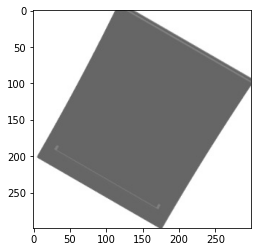

In [15]:
nparr = np.frombuffer(training_data.x_byte[1][20], np.uint8)
img_np = cv2.imdecode(nparr, flags=1)

import matplotlib.pyplot as plt
plt.imshow(img_np)
plt.show()

In [16]:
#https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/
class Model_3d(nn.Module):
    '''
    A model to use on 3d objects
    '''
    def __init__(self, fc_nodes, no_views, no_classes):
      super(Model_3d, self).__init__()
      self.inception = torchvision.models.inception_v3(pretrained=True, aux_logits=False) #https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

      num_features = 1000

      self.fcs = nn.ModuleList()

      for idx in range(no_views):
        self.fcs.append(nn.Linear(num_features, fc_nodes))

      first_dense_count = fc_nodes * no_views

      self.dense_1 = nn.Linear(first_dense_count, no_classes)

    
    def forward(self, x):
      features = []

      for i, fc in enumerate(self.fcs):
        sample = x[:, i, ...]
        r_out = self.inception(sample)
        fc_out = fc(r_out)
        features.append(fc_out)
      
      stack = torch.stack(features, 1)

      reshaped = stack.view([x.shape[0], -1])

      x = self.dense_1(reshaped)


      return torch.nn.functional.softmax(x)

In [17]:
model = Model_3d(1024, 23, 10)
model.to(device)
print(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



cuda:0


In [30]:
#90/10 train val split
train_len = int(len(training_data) * .9)
val_len = len(training_data) - train_len

batch_size = 4

In [31]:
train_set, val_set = torch.utils.data.random_split(training_data, [train_len, val_len],torch.Generator().manual_seed(42))
training_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle=True, num_workers=os.cpu_count())
val_loader = torch.utils.data.DataLoader(val_set, batch_size= batch_size, shuffle=True, num_workers=os.cpu_count())

#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [32]:
#https://medium.com/analytics-vidhya/saving-and-loading-your-model-to-resume-training-in-pytorch-cb687352fa61
def save_ckp(state, model_path):
    torch.save(state, model_path)

In [ ]:
if not os.path.exists(root_dir):
    os.makedirs(root_dir)


low_val_loss = 30000000
best_acc = -1
epoch = 0

val_loss_path = None
acc_path = None
#https://stackoverflow.com/questions/8078330/csv-writing-within-loop
import csv
with open(os.path.join(root_dir, 'logs.csv'), 'w') as file_csv:
  writer=csv.writer(file_csv, delimiter=',',lineterminator='\n',)
  writer.writerow(['epoch', 'loss', 'acc', 'val_loss', 'val_acc'])


  for epoch in range(1, 101):
      row = [epoch]
      is_best = False
      running_loss = 0.0
      correct = 0
      total = 0

      model.train()

      t0 = time.time()
      for i, data in enumerate(training_loader):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # for this_view in range(inputs.shape[1]):
          #   if np.random.randint(0, 4) == 0:
          #     inputs[:, this_view, ...] = 1.0

          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          correct += (outputs.argmax(1) == labels).float().sum() #https://stackoverflow.com/questions/51503851/calculate-the-accuracy-every-epoch-in-pytorch
          total += labels.shape[0]
          running_loss += loss.item()

      print('epoch', epoch)
      
      print('{} seconds'.format(time.time() - t0))
      print('loss', running_loss)
      row.append(running_loss)
      running_loss = 0.0

      accuracy = 100 * correct / total
      print("Accuracy = {}".format(accuracy))
      row.append(torch.IntTensor.item(accuracy))
      correct = 0
      total= 0

      running_loss = 0.0
      correct = 0
      total = 0

      optimizer.zero_grad()
      model.eval()
      t0 = time.time()
      with torch.no_grad():
          for i, data in enumerate(val_loader):
              
              # get the inputs; data is a list of [inputs, labels]
              inputs, labels = data
              inputs = inputs.to(device)
              labels = labels.to(device)        


              # forward + backward + optimize
              outputs = model(inputs)
              loss = criterion(outputs, labels)

              correct += (outputs.argmax(1) == labels).float().sum() #https://stackoverflow.com/questions/51503851/calculate-the-accuracy-every-epoch-in-pytorch
              total += labels.shape[0]
              running_loss += loss.item()

      print('{} seconds'.format(time.time() - t0))
      print('val loss', running_loss)
      row.append(running_loss)
      

      accuracy = 100 * correct / total
      print(" Val Accuracy = {}".format(accuracy))
      row.append(torch.IntTensor.item(accuracy))

      model_name = 'ep_' + str(epoch) + '_loss_' + str(running_loss) + '_acc_' + str(accuracy) + '.pt'
      full_model_path = os.path.join(root_dir, model_name)
      checkpoint = {
          'epoch': epoch + 1,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict()
      }
      if running_loss < low_val_loss:
        if val_loss_path and os.path.exists(val_loss_path):
          open(val_loss_path, 'w').close() #overwrite and make the file blank instead - ref: https://stackoverflow.com/a/4914288/3553367
          os.remove(val_loss_path)
        val_loss_path = full_model_path.replace('.pt', 'val_loss_best.pt')
        save_ckp(model, val_loss_path)
        low_val_loss = running_loss
        print('new low loss')

      if accuracy > best_acc:
        if acc_path and os.path.exists(acc_path):
          open(acc_path, 'w').close() #overwrite and make the file blank instead - ref: https://stackoverflow.com/a/4914288/3553367
          os.remove(acc_path)
        acc_path = full_model_path.replace('.pt', 'acc_best.pt')
        save_ckp(model, acc_path)
        best_acc = accuracy
        print('new best acc')
      full_model_path = os.path.join(root_dir, 'last.pt')
      save_ckp(checkpoint, full_model_path)
          

      

      correct = 0
      total= 0
      running_loss = 0.0
      writer.writerow(row)
  print('Finished Training')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 1
947.5688273906708 seconds
loss 1490.9105277061462
Accuracy = 82.56753540039062
41.12449264526367 seconds
val loss 156.2683242559433
 Val Accuracy = 91.25
new low loss
new best acc
epoch 2
957.1128780841827 seconds
loss 1387.0141483545303
Accuracy = 92.62044525146484
41.656105041503906 seconds
val loss 152.5503625869751
 Val Accuracy = 93.75
new low loss
new best acc
epoch 3
951.2358260154724 seconds
loss 1373.6574475765228
Accuracy = 93.59510040283203
41.66994047164917 seconds
val loss 155.07905626296997
 Val Accuracy = 91.25
epoch 4
954.8850827217102 seconds
loss 1367.7156057357788
Accuracy = 94.235595703125
41.19377279281616 seconds
val loss 150.84167969226837
 Val Accuracy = 95.5
new low loss
new best acc
epoch 5
957.8354046344757 seconds
loss 1357.8538780212402
Accuracy = 95.15455627441406
41.87172865867615 seconds
val loss 152.48405826091766
 Val Accuracy = 94.25
epoch 6
956.4498972892761 seconds
loss 1346.5239137411118
Accuracy = 96.57477569580078
41.822765588760376 secon